# Rotterdam stylized case

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import pickle
import csv

# IMPORT MODEL CLASSES
from classes import *

from collections import OrderedDict

### Load some existing time series

In [2]:
allSurgeSeries = []

SurgeSeries_A = SurgeSeries(allSurgeSeries,"A",'Scenario A: lower part of RCP4.5',None,None) #Je kunt allSurgeSeries ook gewoon bijhouden in de classes.py
SurgeSeries_B = SurgeSeries(allSurgeSeries,"B",'Scenario B: middle of RCP4.5',None,None)
SurgeSeries_C = SurgeSeries(allSurgeSeries,"C",'Scenario C: middle of RCP8.5',None,None)
SurgeSeries_D = SurgeSeries(allSurgeSeries,"D",'Scenario D: upper part of RCP8.5',None,None)
SurgeSeries_A.from_csv("A.csv")
SurgeSeries_B.from_csv("B.csv")
SurgeSeries_C.from_csv("C.csv")
SurgeSeries_D.from_csv("D.csv")

# Build the actual city

In [3]:
#Create Flood Protection objects
#Maeslantkering = FloodProtection("Maeslantkering",5,True)
Dike = FloodProtection("Sea Dike",4.5,False)
No = FloodProtection("No flood protection",4,False) # Assume 3 meter is the natural elevation of the Heijplaat

#Create ResidentialAreas
Area_A = ResidentialArea("Residential area A: the Heijplaat",4,["No flood protection"])
Area_B = ResidentialArea("Residential area B: City Centre",1,["Sea Dike"]) #aan Simon vragen: kan vast mooier koppelen van objecten

#Create Mayor
Berry = Mayor("Berry Kroket")  #AANPASSEN MAYOR

#Create FloodProtectionMeasures
small = Measure("Small dike heightening",0.4,6)
large = Measure("Small dike heightening",1,13)


#### Set parameters

In [4]:
#THRESHOLD FOR THE DEVELOPMENT OF TRUST

alarming_conditions2 = OrderedDict({ #water depth respective to flood protection level, Name of event, reduction of trust if this happens.
    2   : ['Major flood',40], 
    1   : ['Small flood',20],
    0   : ['Near miss',10],
    -0.5  : ['Major wake-up',7],
    -1  : ['Minor wake-up',5],
    -10  : ['Nothing happens',0]
 })

# Run the model (including adaptation functionality)

In [5]:
time = allSurgeSeries[0].years

#RESET THE PROTECTION LEVELS BEFORE A NEW RUN
for FloodProtection in allFloodProtection:
    #FloodProtection.protection_level = [FloodProtection.baseline_level] * len(time)
    FloodProtection.protection_level = OrderedDict() #To track the development of the flood protection levels per storm surge series
    FloodProtection.measure_history = OrderedDict() #To track the development of when decisions were taken
    for SurgeSeries in allSurgeSeries: #STORE THE RESULTS PER STORM SURGE SERIES
        FloodProtection.protection_level[SurgeSeries.name] = [FloodProtection.baseline_level] * len(time)
        FloodProtection.measure_history[SurgeSeries.name] = [None] * len(time)
    
#ADD THE INFORMATION OF THE FLOOD PROTECTION STRUCTURES TO THE AREAS IT PROTECTS
for A in allResidentialArea:
    A.match_with_FloodProtection()

for Area in allResidentialArea:
    Area.trust_t = OrderedDict() #TO TRACK THE DEVELOPMENT OF TRUST
    Area.trust_t[0] = Area.trust_0
    Area.event_impact_history = OrderedDict() #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
    Area.flood_history = OrderedDict() #TO SAVE FLOOD DEPTHS PER YEAR [IN M]
    for SurgeSeries in allSurgeSeries: #STORE THE RESULTS PER NAME OF THE STORM SURGE SERIES AS KEYS IN ORDERED DICT
        Area.trust_t[SurgeSeries.name] = [None] * len(time)
        Area.trust_t[SurgeSeries.name][0] = Area.trust_0
        Area.event_impact_history[SurgeSeries.name] = [None] * len(time) #TO SAVE VALUES OF THE 'ALARMING CONDITIONS'
        Area.flood_history[SurgeSeries.name] = [None] * len(time) #TO SAVE FLOOD DEPTHS PER YEAR [IN M]

for SurgeSeries in allSurgeSeries:
    print(SurgeSeries.name)
    # THE MODEL RUNS OVER A YEARLY TIMESTEP
    for i,t in enumerate(time): #Iterate over the years t, with index i
        #print(i,t)

        for Area in allResidentialArea:
            #FIRST EVALUATE IF THE FLOOD PROTECTION LEVEL IS EXCEEDED (TO DETERMINE IF FLOOD HAPPENS)
            if Area.protection_level[SurgeSeries.name][i] < SurgeSeries.surgelevel[i]: #if a flood occurs
                Area.flood_history[SurgeSeries.name][i] = SurgeSeries.surgelevel[i] - Area.elevation
                #print("{} is inundated with a water depth of {} m \n --> damage occurs".format(Area.name,Area.flood_history[i]))

            #THEN EVALUATE THE IMPACT ON TRUST
            if i != 0: #don't evaluate trust in the first timestep!
                #print(Area.protection_level-levels_t[i])
                Area.event_impact_history[SurgeSeries.name][i] = evaluate_event(SurgeSeries.surgelevel[i]-Area.protection_level[SurgeSeries.name][i],alarming_conditions2,False)
                #First evaluate the impact of this year's event (if any)

                Area.trust_t[SurgeSeries.name][i] = Area.trust_t[SurgeSeries.name][i-1] - Area.event_impact_history[SurgeSeries.name][i]

                #ALWAYS MODEL RECOVERY OF TRUST
                k = 0.2 
                T_eq = 70
                dTdt = (Area.trust_t[SurgeSeries.name][i]-T_eq)*-k
                Area.trust_t[SurgeSeries.name][i] = Area.trust_t[SurgeSeries.name][i] + dTdt
            
        #IMPLEMENT FLOOD PROTECTION MEASURES
        if allResidentialArea[1].event_impact_history[SurgeSeries.name][i] == 7:
            print("Update necessary in year {}".format(i))

            Measure = allMeasure[0]
            Dike.measure_history[SurgeSeries.name][i] = Measure.increase

            Dike.update_protection_level(SurgeSeries.name,start=i+Measure.lead_time,end=len(time),newvalue=Dike.protection_level[SurgeSeries.name][i]+Measure.increase)
            for A in allResidentialArea:
                A.match_with_FloodProtection()

A
B
Update necessary in year 84
C
Update necessary in year 55
Update necessary in year 76
Update necessary in year 84
Update necessary in year 85
Update necessary in year 96
Update necessary in year 98
D
Update necessary in year 53
Update necessary in year 57
Update necessary in year 63
Update necessary in year 65
Update necessary in year 69
Update necessary in year 70
Update necessary in year 76
Update necessary in year 78
Update necessary in year 80
Update necessary in year 81
Update necessary in year 83
Update necessary in year 86
Update necessary in year 88
Update necessary in year 89
Update necessary in year 90
Update necessary in year 91
Update necessary in year 92
Update necessary in year 93
Update necessary in year 94
Update necessary in year 95
Update necessary in year 97


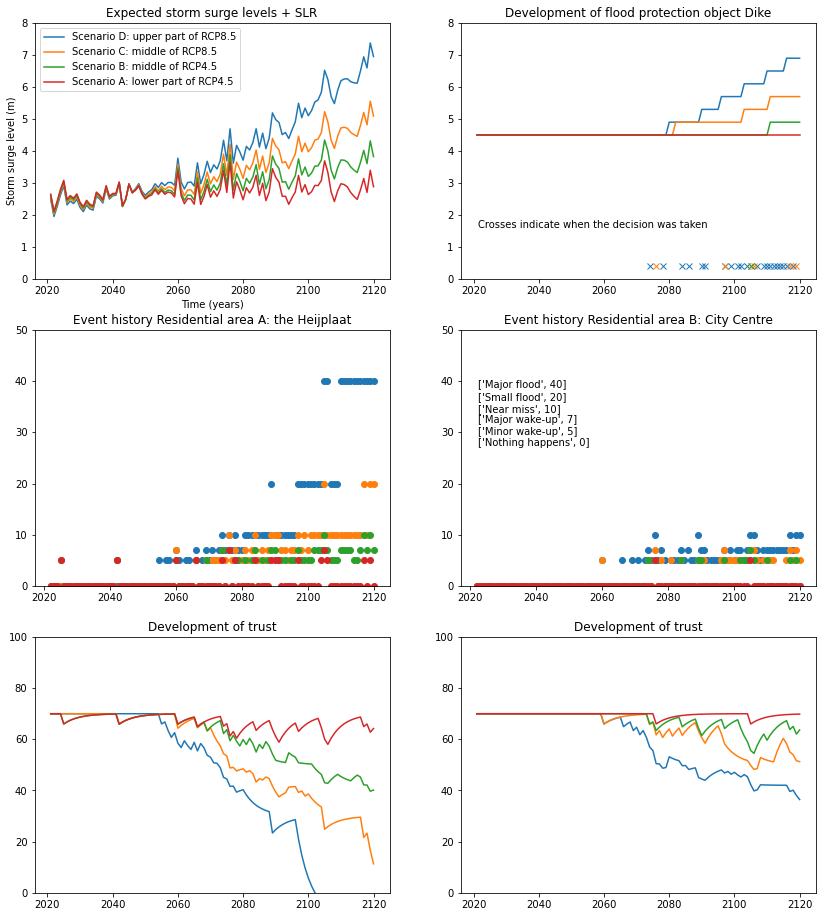

In [39]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharey=False,figsize=(14,16))

labels = []

for SurgeSeries in reversed(allSurgeSeries):
    axes[0,0].plot(SurgeSeries.years,SurgeSeries.surgelevel)

    labels.append(SurgeSeries.description)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)

    for i, Area in enumerate(allResidentialArea):
        axes[1,i].set_title('Event history {}'.format(allResidentialArea[i].name))
        axes[1,i].plot(SurgeSeries.years,allResidentialArea[i].event_impact_history[SurgeSeries.name],'o')
        axes[1,i].set_ylim(0,50)
        
        axes[2,i].set_title('Development of trust')
        axes[2,i].plot(SurgeSeries.years,allResidentialArea[i].trust_t[SurgeSeries.name],)

        axes[2,i].set_ylim(0,100)
    

    axes[0,1].plot(allSurgeSeries[0].years,Dike.protection_level[SurgeSeries.name])
    axes[0,1].set_title('Development of flood protection object Dike')
    
axes[0,0].legend(labels)

#Add some additional text to some axes
textbox = ""
for key in alarming_conditions2:
    textbox = textbox + str(alarming_conditions2[key]) + '\n'

axes[0,1].text(0.05,0.2,"Crosses indicate when the decision was taken",transform=axes[0,1].transAxes)
axes[1,1].text(0.05,0.5,textbox,transform=axes[1,1].transAxes)


axes[0,1].set_prop_cycle(None) #reset the cycler to plot again in the same axes with similar colors
for SurgeSeries in reversed(allSurgeSeries):
    axes[0,1].plot(allSurgeSeries[0].years,Dike.measure_history[SurgeSeries.name],'x') #PLOT THE HISTORY OF THE MEASURES
    